# Fast tokenizers in the QA pipeline (PyTorch)

(Быстрые токенизаторы в конвейере QA)
Теперь мы погрузимся в конвейер вопросов и ответов и посмотрим, как использовать смещения, чтобы извлечь ответ на вопрос из контекста, немного похоже на то, как мы делали для сгруппированных сущностей в предыдущем разделе. Затем мы увидим, как мы можем справиться с очень длинными контекстами, которые в итоге оказываются усеченными.

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

## Using the question-answering pipeline

In [2]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch, and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cpu


{'score': 0.9802603125572205,
 'start': 78,
 'end': 106,
 'answer': 'Jax, PyTorch, and TensorFlow'}

В отличие от других конвейеров, которые не могут обрезать и разбивать тексты, длина которых превышает максимально допустимую моделью (и, таким образом, могут быть упущены данные в конце документа), этот конвейер может работать с очень длинными контекстами и вернет ответ на вопрос, даже если он находится в конце:

In [3]:
long_context = """
🤗 Transformers: State of the Art NLP

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified API for using all our pretrained models.
  - Lower compute costs, smaller carbon footprint:

2. Researchers can share trained models instead of always retraining.
  - Practitioners can reduce compute time and production costs.
  - Dozens of architectures with over 10,000 pretrained models, some in more than 100 languages.

3. Choose the right framework for every part of a model's lifetime:
  - Train state-of-the-art models in 3 lines of code.
  - Move a single model between TF2.0/PyTorch frameworks at will.
  - Seamlessly pick the right framework for training, evaluation and production.

4. Easily customize a model or an example to your needs:
  - We provide examples for each architecture to reproduce the results published by its original authors.
  - Model internals are exposed as consistently as possible.
  - Model files can be used independently of the library for quick experiments.

🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question_answerer(question=question, context=long_context)

{'score': 0.9714871048927307,
 'start': 1892,
 'end': 1919,
 'answer': 'Jax, PyTorch and TensorFlow'}

Let’s see how it does all of this!

## Using a model for question answering

Как и в случае с любым другим конвейером, мы начинаем с токенизации наших входных данных, а затем отправляем их через модель. Контрольная точка, используемая по умолчанию для вопросно-ответного конвейера, — это distilbert-base-cased-distilled-squad («squad» в названии происходит от набора данных, на котором была настроена модель; мы поговорим подробнее о наборе данных SQuAD в Главе 7):

In [4]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

model_checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="pt")
outputs = model(**inputs)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

Note that we tokenize the question and the context as a pair, with the question first.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


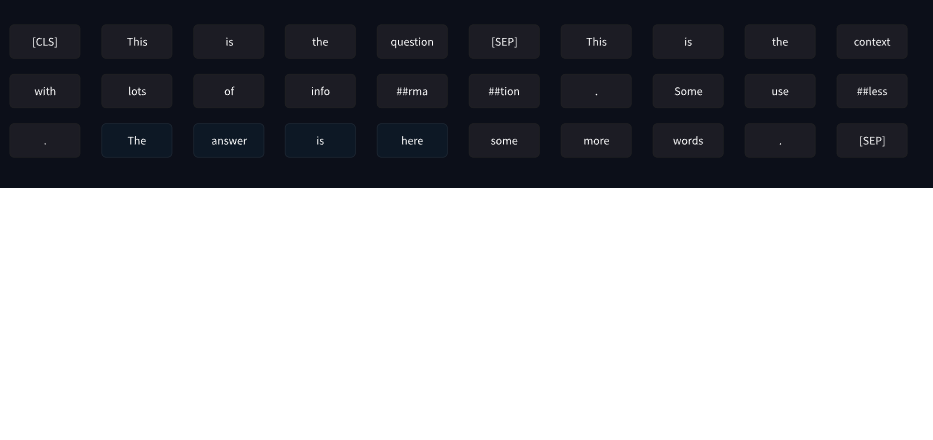

In [7]:
file_path = "/content/drive/My Drive/Hugging_face/QA.png"

from IPython.display import display
from PIL import Image

# Открываем и отображаем изображение
img = Image.open(file_path)  # Укажите путь к файлу
display(img)

Модели для вопросов-ответов работают немного иначе, чем модели, которые мы видели до сих пор. Используя картинку выше в качестве примера, модель была обучена предсказывать индекс токена, начинающего ответ (здесь 21), и индекс токена, на котором заканчивается ответ (здесь 24). Вот почему эти модели возвращают не один тензор логитов, а два: один для логитов, соответствующих начальному токену ответа, и один для логитов, соответствующих конечному токену ответа. Поскольку в этом случае у нас есть только один вход, содержащий 66 токенов, мы получаем:

In [8]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([1, 67]) torch.Size([1, 67])


Чтобы преобразовать эти логиты в вероятности, мы применим функцию softmax — но перед этим нам нужно убедиться, что мы замаскировали индексы, которые не являются частью контекста. Наши входные данные — [CLS] вопрос [SEP] контекст [SEP], поэтому нам нужно замаскировать токены вопроса, а также токен [SEP]. Однако мы сохраним токен [CLS], так как некоторые модели используют его для указания того, что ответ не находится в контексте.

Поскольку мы применим softmax позже, нам просто нужно заменить логиты, которые мы хотим замаскировать, большим отрицательным числом. Здесь мы используем -10000:

In [9]:
import torch

sequence_ids = inputs.sequence_ids()
# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Unmask the [CLS] token
mask[0] = False
mask = torch.tensor(mask)[None]

start_logits[mask] = -10000
end_logits[mask] = -10000

Теперь, когда мы правильно замаскировали логиты, соответствующие позициям, которые мы не хотим предсказывать, мы можем применить softmax:

In [10]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)[0]
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)[0]

На этом этапе мы могли бы взять argmax начальных и конечных вероятностей — но мы можем получить начальный индекс, который больше конечного индекса, поэтому нам нужно принять еще несколько мер предосторожности. Мы вычислим вероятности каждого возможного start_index и end_index, где start_index <= end_index, затем возьмем кортеж (start_index, end_index) с самой высокой вероятностью.

Если предположить, что события «Ответ начинается с start_index» и «Ответ заканчивается end_index» независимы, то вероятность того, что ответ начинается с start_index и заканчивается end_index, равна:
```
start_probabilities[start_index]×end_probabilities[end_index]
```
Итак, чтобы вычислить все баллы, нам просто нужно вычислить все произведения
```
start_probabilities[start_index]×end_probabilities[end_index] where start_index <= end_index.
```

Сначала давайте вычислим все возможные продукты:

In [13]:
scores = start_probabilities[:, None] * end_probabilities[None, :]

Затем мы замаскируем значения, где start_index > end_index, установив их в 0 (все остальные вероятности — положительные числа). Функция torch.triu() возвращает верхнюю треугольную часть 2D-тензора, переданного в качестве аргумента, поэтому она выполнит эту маскировку за нас:

In [12]:
scores = torch.triu(scores)

Теперь нам просто нужно получить индекс максимума. Поскольку PyTorch вернет индекс в сглаженном тензоре, нам нужно использовать операции деления пола // и модуля %, чтобы получить start_index и end_index:

In [14]:
max_index = scores.argmax().item()
start_index = max_index // scores.shape[1]
end_index = max_index % scores.shape[1]
print(scores[start_index, end_index])

tensor(0.9803, grad_fn=<SelectBackward0>)


У нас есть start_index и end_index ответа в терминах токенов, так что теперь нам просто нужно преобразовать их в индексы символов в контексте. Вот где смещения будут очень полезны. Мы можем взять их и использовать, как мы делали в задаче классификации токенов:

In [15]:
inputs_with_offsets = tokenizer(question, context, return_offsets_mapping=True)
offsets = inputs_with_offsets["offset_mapping"]

start_char, _ = offsets[start_index]
_, end_char = offsets[end_index]
answer = context[start_char:end_char]

Теперь нам осталось только все отформатировать, чтобы получить наш результат:

In [16]:
result = {
    "answer": answer,
    "start": start_char,
    "end": end_char,
    "score": scores[start_index, end_index],
}
print(result)

{'answer': 'Jax, PyTorch, and TensorFlow', 'start': 78, 'end': 106, 'score': tensor(0.9803, grad_fn=<SelectBackward0>)}


## Обработка длинных контекстов

Если мы попытаемся токенизировать вопрос и длинный контекст, которые мы использовали в качестве примера ранее, мы получим количество токенов, превышающее максимальную длину, используемую в конвейере вопросов и ответов (которая составляет 384):

In [18]:
inputs = tokenizer(question, long_context)
print(len(inputs["input_ids"]))

461


Итак, нам нужно будет обрезать наши входные данные до этой максимальной длины. Есть несколько способов сделать это, но мы не хотим обрезать вопрос, только контекст. Поскольку контекст — это второе предложение, мы будем использовать стратегию обрезания «only_second». Проблема, которая возникает тогда, заключается в том, что ответ на вопрос может не быть в обрезанном контексте. Здесь, например, мы выбрали вопрос, где ответ находится ближе к концу контекста, и когда мы обрезаем его, этот ответ отсутствует:

In [19]:
inputs = tokenizer(question, long_context, max_length=384, truncation="only_second")
print(tokenizer.decode(inputs["input_ids"]))

[CLS] Which deep learning libraries back [UNK] Transformers? [SEP] [UNK] Transformers : State of the Art NLP [UNK] Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction, question answering, summarization, translation, text generation and more in over 100 languages. Its aim is to make cutting - edge NLP easier to use for everyone. [UNK] Transformers provides APIs to quickly download and use those pretrained models on a given text, fine - tune them on your own datasets and then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and can be modified to enable quick research experiments. Why should I use transformers? 1. Easy - to - use state - of - the - art models : - High performance on NLU and NLG tasks. - Low barrier to entry for educators and practitioners. - Few user - facing abstractions with just three classes to learn. - A unified A

Это означает, что модели будет сложно выбрать правильный ответ. Чтобы исправить это, конвейер вопросов и ответов позволяет нам разбить контекст на более мелкие фрагменты, указав максимальную длину. Чтобы убедиться, что мы не разобьем контекст в совершенно неправильном месте, чтобы сделать возможным поиск ответа, он также включает некоторое перекрытие между фрагментами.

Мы можем заставить токенизатор (быстрый или медленный) сделать это за нас, добавив return_overflowing_tokens=True, и мы можем указать нужное нам перекрытие с помощью аргумента шага. Вот пример с использованием более короткого предложения:

In [20]:
sentence = "This sentence is not too long but we are going to split it anyway."
inputs = tokenizer(
    sentence, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] This sentence is not [SEP]
[CLS] is not too long [SEP]
[CLS] too long but we [SEP]
[CLS] but we are going [SEP]
[CLS] are going to split [SEP]
[CLS] to split it anyway [SEP]
[CLS] it anyway. [SEP]


Как мы видим, предложение было разделено на части таким образом, что каждая запись в inputs["input_ids"] имеет не более 6 токенов (нам нужно будет добавить отступ, чтобы последняя запись была того же размера, что и остальные), и между каждой из записей есть перекрытие в 2 токена.

Давайте подробнее рассмотрим результат токенизации:

In [21]:
print(inputs.keys())

dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping'])


Как и ожидалось, мы получаем идентификаторы ввода и маску внимания. Последний ключ, overflow_to_sample_mapping, — это карта, которая сообщает нам, какому предложению соответствует каждый из результатов — здесь у нас есть 7 результатов, которые все исходят из (единственного) предложения, которое мы передали токенизатору:

In [22]:
print(inputs["overflow_to_sample_mapping"])

[0, 0, 0, 0, 0, 0, 0]


This is more useful when we tokenize several sentences together. For instance, this:

In [23]:
sentences = [
    "This sentence is not too long but we are going to split it anyway.",
    "This sentence is shorter but will still get split.",
]
inputs = tokenizer(
    sentences, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2
)

print(inputs["overflow_to_sample_mapping"])

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


что означает, что первое предложение разделено на 7 частей, как и прежде, а следующие 4 части берутся из второго предложения.

Теперь вернемся к нашему длинному контексту. По умолчанию вопросно-ответный конвейер использует максимальную длину 384, как мы уже упоминали ранее, и шаг 128, что соответствует способу тонкой настройки модели (вы можете настроить эти параметры, передав аргументы max_seq_len и stride при вызове конвейера). Таким образом, мы будем использовать эти параметры при токенизации. Мы также добавим заполнение (чтобы иметь образцы одинаковой длины, чтобы мы могли строить тензоры), а также запросим смещения:

In [24]:
inputs = tokenizer(
    question,
    long_context,
    stride=128,
    max_length=384,
    padding="longest",
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

Эти входные данные будут содержать идентификаторы входных данных и маски внимания, которые ожидает модель, а также смещения и overflow_to_sample_mapping, о которых мы только что говорили. Поскольку эти два параметра не используются моделью, мы вытащим их из входных данных (и не будем хранить карту, поскольку она здесь бесполезна) перед ее преобразованием в тензор:

In [25]:
_ = inputs.pop("overflow_to_sample_mapping")
offsets = inputs.pop("offset_mapping")

inputs = inputs.convert_to_tensors("pt")
print(inputs["input_ids"].shape)

torch.Size([2, 384])


In [31]:
outputs = model(**inputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([2, 384]) torch.Size([2, 384])


Наш длинный контекст был разделен на две части, что означает, что после того, как он пройдет через нашу модель, у нас будет два набора начальных и конечных логитов:

Как и прежде, мы сначала маскируем токены, которые не являются частью контекста, прежде чем брать softmax. Мы также маскируем все токены заполнения (как отмечено маской внимания):

In [32]:
sequence_ids = inputs.sequence_ids()
# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Unmask the [CLS] token
mask[0] = False
# Mask all the [PAD] tokens
mask = torch.logical_or(torch.tensor(mask)[None], (inputs["attention_mask"] == 0))

start_logits[mask] = -10000
end_logits[mask] = -10000

Затем мы можем использовать softmax для преобразования наших логитов в вероятности:

In [34]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)

Следующий шаг похож на тот, что мы сделали для малого контекста, но мы повторяем его для каждого из наших двух фрагментов. Мы присваиваем оценку всем возможным диапазонам ответа, затем берем диапазон с лучшим баллом:

In [35]:
candidates = []
for start_probs, end_probs in zip(start_probabilities, end_probabilities):
    scores = start_probs[:, None] * end_probs[None, :]
    idx = torch.triu(scores).argmax().item()

    start_idx = idx // scores.shape[1]
    end_idx = idx % scores.shape[1]
    score = scores[start_idx, end_idx].item()
    candidates.append((start_idx, end_idx, score))

print(candidates)

[(0, 18, 0.33866992592811584), (173, 184, 0.9714868664741516)]


Эти два кандидата соответствуют лучшим ответам, которые модель смогла найти в каждом фрагменте. Модель гораздо более уверена, что правильный ответ находится во второй части (что является хорошим знаком!). Теперь нам просто нужно сопоставить эти два диапазона токенов с диапазонами символов в контексте (нам нужно сопоставить только второй, чтобы получить наш ответ, но интересно посмотреть, что модель выбрала в первом фрагменте).

In [36]:
for candidate, offset in zip(candidates, offsets):
    start_token, end_token, score = candidate
    start_char, _ = offset[start_token]
    _, end_char = offset[end_token]
    answer = long_context[start_char:end_char]
    result = {"answer": answer, "start": start_char, "end": end_char, "score": score}
    print(result)

{'answer': '\n🤗 Transformers: State of the Art NLP', 'start': 0, 'end': 37, 'score': 0.33866992592811584}
{'answer': 'Jax, PyTorch and TensorFlow', 'start': 1892, 'end': 1919, 'score': 0.9714868664741516}


На этом мы завершаем наше глубокое погружение в возможности токенизатора. Мы снова применим все это на практике в следующей главе, когда покажем вам, как тонко настроить модель на ряд распространенных задач NLP.